# Automating TS generation and optimization with RDkit and XTB/ORCA: Tutorial 
Spring 2022 Coding Camp - Liliana C. Gallegos

In [1]:
## Activate DL_CPU environment
import os
from rdkit.Chem import AllChem as Chem


## Ignore warnings and errors from rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.error')
RDLogger.DisableLog('rdApp.warning')


In [2]:
wdir = '/home/liliana/projects/BH-project/coding_camp_tutorial'
os.chdir(wdir)
cur_path = os.getcwd(); #print(cur_path)
print('Current Path: {}'.format(cur_path))

from TS_workflow_fxns import *

Current Path: /home/liliana/projects/BH-project/coding_camp_tutorial


## I. C-N bond reaction with SMARTS

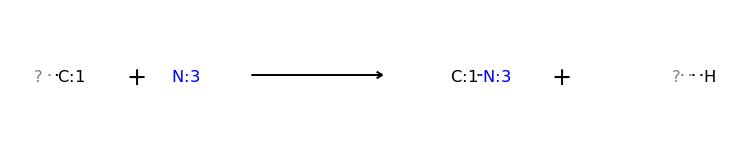

In [3]:
# SMARTS Reaction 
rxn = Chem.ReactionFromSmarts('[#6:1]([Cl,Br,I:2]).[#7+0:3]>>[#6:1][#7+0:3].[Cl,Br,I:2][H]')
rxn  # ? = Cl, Br, or I Halide

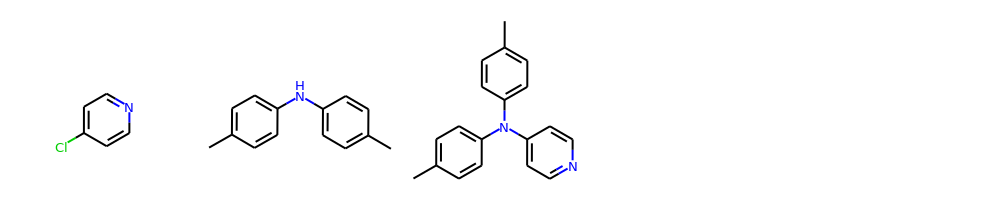

In [4]:
# Example 1
aryl  = 'ClC1=CC=NC=C1' 
amine = '[H]N(C1=CC=C(C)C=C1)C2=CC=C(C)C=C2'

mol1 = Chem.MolFromSmiles(aryl)
mol2 = Chem.MolFromSmiles(amine)

prod = rxn.RunReactants((mol1, mol2))[0][0]
list_rxts = [mol1, mol2, prod]
Draw.MolsToGridImage(list_rxts, molsPerRow=5)

## II. Building metal-complex intermediates

In [5]:
# Example 2
def RE_intermediate(ligand, aryl, amine):
    '''
    Generates reductive elimination intermediate from substrate smiles.
    Input smiles for ligand, aryl, and amine. Returns the mol object for intermediate.
    '''
    # Convert to mol objects from given substrate smiles
    Pd2_mol  = Chem.MolFromSmiles('Cl[Pd]Cl')
    lig_mol  = Chem.MolFromSmiles(ligand)
    ar_mol = Chem.MolFromSmiles(aryl)
    am_mol = Chem.MolFromSmiles(amine)
    
    # Build intermediate with SMARTS
    rxn2 = Chem.ReactionFromSmarts('[P:1].[Pd:2][Cl]>>[Pd:2]([P+:1])')
    rxn3 = Chem.ReactionFromSmarts('([P:1].[Pd:2]([P+:3])[Cl:4])>>[P+:1][Pd:2]([P+:3])')
    rxn4 = Chem.ReactionFromSmarts('[Pd:1].[#6:2]([Cl,Br,I:3]).[#7:4]>>[Pd:1]([#6:2])([#7:4]).[Cl,Br,I:3].[H]') 
    
    inter1 = rxn2.RunReactants((lig_mol, Pd2_mol))[0][0]
    inter2 = rxn3.RunReactants((inter1,))[0][0]
    intermediate = rxn4.RunReactants((inter2, ar_mol, am_mol))[0][0]
    Chem.SanitizeMol(intermediate)

    return intermediate

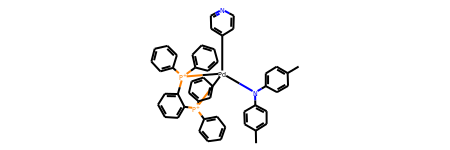

In [6]:
# tetrahedral geometry
BisPP  = 'C1(P(C2=CC=CC=C2P(C3=CC=CC=C3)C4=CC=CC=C4)C5=CC=CC=C5)=CC=CC=C1'
re_int = RE_intermediate(BisPP, aryl, amine)
re_int

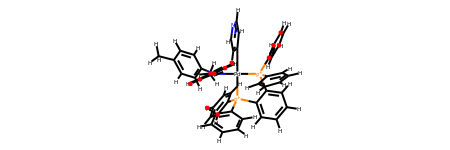

In [7]:
# square-planar geometry
os.chdir(wdir)
re_int = embed_sqplanar_template(re_int)
re_int

## III. Building TS structures 
For more chemical transformations (manipulations) of structures: https://www.rdkit.org/docs/source/rdkit.Chem.rdMolTransforms.html

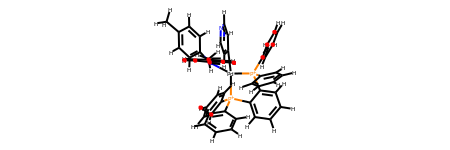

In [8]:
#### Transformations with RDkit
angle, dist1, dist2 = 56.0, 2.0, 2.1
re_ts = build_TS(re_int, angle, dist1, dist2)
new_ts, atoms, symbol, coords = get_minstructure(re_ts, n_confs=50)
new_ts

## IV. Going 3D...
Create directory with required files to run XTB.
For more solvents in xtb/crest: https://xtb-docs.readthedocs.io/en/latest/CENSO_docs/censo_solvation.html

In [9]:
# generate XTB files
charge = Chem.GetFormalCharge(re_int)-2
solvent = 'toluene'

path = wdir
status_int = mol2xtb('RE_INT', re_int, charge, solvent, path)
status_ts  = mol2xtb('RE_TS', new_ts, charge, solvent, path, TS=True)

print('Created INT: {}'.format(status_int))
print('Created TS: {}'.format(status_ts))

Created INT: True
Created TS: True


## V. Application on combinatorial reactants

In [10]:
# Load SMILES 
os.chdir(wdir)
cn_df = pd.read_csv('CN-reactants.csv')
cn_df.head()

,Reaction,Amine,Halide,P-Ligand,dG_re
0,CN_001,[H]N(C1=CC=C(C)C=C1)C2=CC=C(C)C=C2,ClC1=CC=NC=C1,C1(P(C2=CC=CC=C2P(C3=CC=CC=C3)C4=CC=CC=C4)C5=C...,22.74
1,CN_002,CN(C)[H],BrC1=CC=NC=C1,CC1(C)C2=C(OC3=C1C=CC=C3P(C4=CC=CC=C4)C5=CC=CC...,10.72
2,CN_003,[H]N1[C@@H](C)CCC[C@@H]1C,ClC1=CC=NC=C1F,C1(P(/C=C\P(C2=CC=CC=C2)C3=CC=CC=C3)C4=CC=CC=C...,8.05


Preparing: CN_001
Preparing: CN_002
Preparing: CN_003


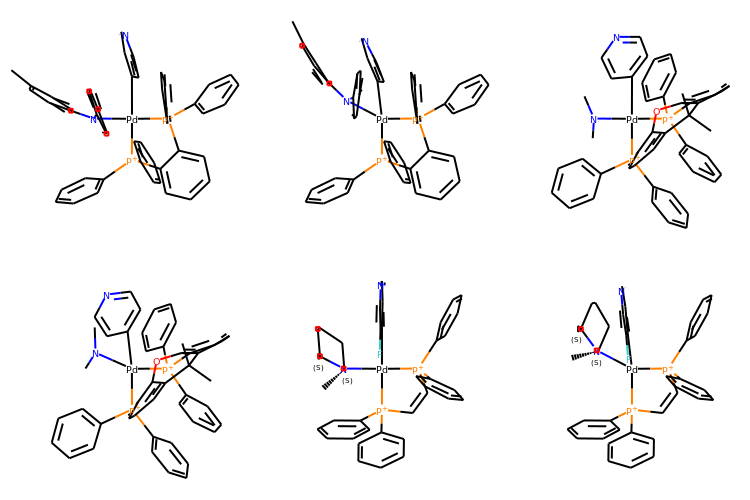

In [12]:
solvent = 'toluene'
path = wdir
# path = '/home/liliana/projects/BH-project/coding_camp_tutorial/Example-ORCA-results'

# main
paths, mols = [], []
for name, lig, ar, am in zip(cn_df['Reaction'], cn_df['P-Ligand'], cn_df['Halide'], cn_df['Amine']):
    os.chdir(wdir)
    print('Preparing: {}'.format(name))
    
    # generate metal-complex intermediate
    int_mol = RE_intermediate(lig, ar, am)
    charge = Chem.GetFormalCharge(int_mol)-2
    
    int_mol = embed_sqplanar_template(int_mol)
    new_int, _, _, _ = get_minstructure(int_mol, n_confs=10)
    mol2xtb(name, new_int, charge, solvent, path, TS=False, nproc=2)
    paths.append(os.getcwd()); mols.append(Chem.RemoveHs(new_int))
    
    # generate ts
    angle, dist1, dist2 = 56.0, 2.0, 2.1
    re_ts = build_TS(new_int, angle, dist1, dist2)
    mol2xtb(name+'_TS', re_ts, charge, solvent, path, TS=True, nproc=2)
    paths.append(os.getcwd()); mols.append(Chem.RemoveHs(re_ts))

Draw.MolsToGridImage(mols, subImgSize=(250,250), molsPerRow=3)

## VI. XTB TS optimization: 
### (a) Run calcs
Estimated process time on local computer: 101 secs

In [16]:
print('Total calculations to submit: {}'.format(len(paths)))

os.chdir(wdir)
create_batch(paths, script='xtb', chunk_size=6)

Total calculations to submit: 6


True

### (b) Collect thermodata
After xtb calculations have completed:

In [17]:
filenames = [ p.split('/')[-1] for p in paths]
print('Thermodata for file: {}'.format(filenames[0]))

os.chdir(path)
free_energies, ZPEs, n_imags, imag_freqs = read_xtb_out(filenames[0])
print(free_energies, ZPEs, n_imags, imag_freqs)

Thermodata for file: CN_001
[-141.216750274031] [0.74159549094] [0] [None]


In [18]:
# Check for imagingary frequencies
for file in filenames:
    os.chdir(path)
    free_energies, ZPEs, n_imags, imag_freqs = read_xtb_out(file)
    if file.find('TS') > -1:
        print(file, imag_freqs)

CN_001_TS [None]
CN_002_TS [['-256.19']]
CN_003_TS [['-273.90']]


In [19]:
# Reaction barrier calculation 
xtb_dGs = []
for rxn in cn_df['Reaction']:
    G_int, G_TS = [], []
    for file in filenames:
        os.chdir(path)
        name = file.split('/')[-1]
        free_energies, ZPEs, n_imags, imag_freqs = read_xtb_out(name)
        if file.find(rxn) > -1:
            if name.find('TS') > -1:
                    G_TS.append(free_energies[0])
            else: G_int.append(free_energies[0])
            print(name, free_energies, imag_freqs)
    dGs = round((G_TS[0] - G_int[0])*627.5,1)
    xtb_dGs.append(dGs)
    print('Reaction barrier: {}\n'.format(dGs))

CN_001 [-141.216750274031] [None]
CN_001_TS [-141.19260444103] [['-247.66', '-35.13']]
Reaction barrier: 15.2

CN_002 [-138.868690667741] [None]
CN_002_TS [-138.842593854708] [['-256.19']]
Reaction barrier: 16.4

CN_003 [-120.91042047006] [None]
CN_003_TS [-120.900468554231] [['-273.90']]
Reaction barrier: 6.2



## VIII. ORCA TS optimization

In [20]:
#solvent = 'toluene'
path = wdir

# main
paths, mols = [], []
for name, lig, ar, am in zip(cn_df['Reaction'], cn_df['P-Ligand'], cn_df['Halide'], cn_df['Amine']):
    os.chdir(wdir)
    print('Preparing: {}'.format(name))
    
    # generate metal-complex intermediate
    int_mol = RE_intermediate(lig, ar, am)
    charge = Chem.GetFormalCharge(int_mol)-2
    
    int_mol = embed_sqplanar_template(int_mol)
    new_int, _, _, _ = get_minstructure(int_mol, n_confs=10)
    #mol2xtb(name, new_int, charge, solvent, path, TS=False, nproc=2)      ## XTB opt
    mol2orca(name, new_int, charge, path, xtb=True, TS=False, nproc=4)     ## ORCA opt
    paths.append(os.getcwd()); mols.append(Chem.RemoveHs(new_int))
    
    # generate ts
    angle, dist1, dist2 = 56.0, 2.0, 2.1
    re_ts = build_TS(new_int, angle, dist1, dist2)
    #mol2xtb(name+'_TS', re_ts, charge, solvent, path, TS=True, nproc=2)   ## XTB opt
    mol2orca(name+'_TS', re_ts, charge, path, xtb=True, TS=True, nproc=4)  ## ORCA opt
    paths.append(os.getcwd()); mols.append(Chem.RemoveHs(re_ts))

print('Total calculations to submit: {}'.format(len(paths)))

Preparing: CN_001
Preparing: CN_002
Preparing: CN_003
Total calculations to submit: 6


In [21]:
# create batch script for submission
os.chdir(wdir)
create_batch(paths, script='orca1', chunk_size=3)
create_batch(paths, script='orca2', chunk_size=3)

True

In [22]:
# from previously ran ORCA optimization calcs
path = '/home/liliana/projects/BH-project/coding_camp_tutorial/Example-ORCA-results'

# Collect data after ORCA2 script completes
os.chdir(path)
free_energies, n_imag, imag_freqs = read_orca_out('CN_001_TS')
print(free_energies, n_imag, imag_freqs)

[-141.10756973] 1 [-354.87]


In [23]:
# Reaction barrier calculation
# from previously ran ORCA optimization calcs
os.chdir(wdir+'/Example-ORCA-results')
filenames = glob.glob(wdir+'/Example-ORCA-results/'+'CN*')

orca_dGs = [] 
for rxn in cn_df['Reaction']:
    G_int, G_TS = [], []
    for file in filenames:
        os.chdir(path)
        if file.find(rxn) > -1:
            name = file.split('/')[-1]
            free_energies, n_imags, imag_freqs = read_orca_out(name)
#         print(file, free_energies, n_imag, imag_freqs)
            if len(free_energies) == 0: 
                Gs.append(float(0))
                pass
            else:
                if name.find('TS') > -1:
                    G_TS.append(free_energies[0])
                else: G_int.append(free_energies[0])
                print(name, free_energies, imag_freqs)
    dGs = round((G_TS[0] - G_int[0])*627.5,1)
    orca_dGs.append(dGs)
    print('Reaction barrier: {}\n'.format(dGs))

CN_001 [-141.12957268] []
CN_001_TS [-141.10756973] [-354.87]
Reaction barrier: 13.8

CN_002_TS [-138.77553467] [-237.48]
CN_002 [-138.79398724] []
Reaction barrier: 11.6

CN_003_TS [-120.80554079] [-215.84]
CN_003 [-120.82400037] []
Reaction barrier: 11.6



# IX. To view imag frequency with Molden:
* orca_pltvib filename_opt.out 6 
* molden filename_opt.out.v006.xyz

## X. Compare reaction barriers to DFT

In [24]:
# Compare results
cn_df['RE dG_xtb']  = xtb_dGs
cn_df['RE dG_orca'] = orca_dGs
cn_df['XTB error']  = cn_df['dG_re'] - cn_df['RE dG_xtb']
cn_df['ORCA error'] = cn_df['dG_re'] - cn_df['RE dG_orca']
cn_df.head()

,Reaction,Amine,Halide,P-Ligand,dG_re,RE dG_xtb,RE dG_orca,XTB error,ORCA error
0,CN_001,[H]N(C1=CC=C(C)C=C1)C2=CC=C(C)C=C2,ClC1=CC=NC=C1,C1(P(C2=CC=CC=C2P(C3=CC=CC=C3)C4=CC=CC=C4)C5=C...,22.74,15.2,13.8,7.54,8.94
1,CN_002,CN(C)[H],BrC1=CC=NC=C1,CC1(C)C2=C(OC3=C1C=CC=C3P(C4=CC=CC=C4)C5=CC=CC...,10.72,16.4,11.6,-5.68,-0.88
2,CN_003,[H]N1[C@@H](C)CCC[C@@H]1C,ClC1=CC=NC=C1F,C1(P(/C=C\P(C2=CC=CC=C2)C3=CC=CC=C3)C4=CC=CC=C...,8.05,6.2,11.6,1.85,-3.55


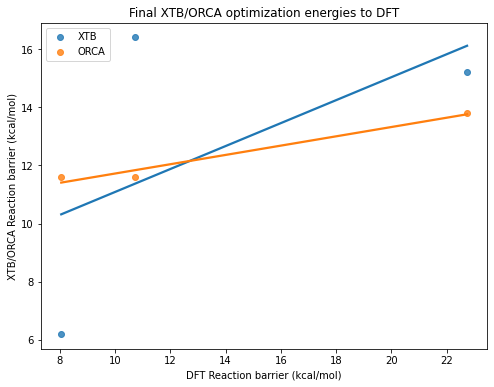

In [25]:
# For plotting
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
# points = plt.scatter(beta, Sig2, c=dG_exp, s=75, cmap="Spectral_r")
sns.regplot(x="dG_re", y="RE dG_xtb", data=cn_df, ci=None, label='XTB')
sns.regplot(x="dG_re", y="RE dG_orca", data=cn_df, ci=None, label='ORCA')

plt.title('Final XTB/ORCA optimization energies to DFT')
plt.xlabel('DFT Reaction barrier (kcal/mol)')
plt.ylabel('XTB/ORCA Reaction barrier (kcal/mol)')
plt.legend();